In [27]:
from itertools import cycle
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import torch

In [28]:
device = torch.device('mps')
print('Using device:', device)

Using device: mps


In [29]:
df = pd.read_excel('Kato_data/Stim1.xlsx')
df.head()

Unnamed: 0        []      [].1      [].2      [].3      [].4      [].5  \
0           1  0.143489  0.258633  0.291744  0.290205  0.213816  0.278162   
1           2  0.105042  0.256738  0.275111  0.244603  0.196733  0.302802   
2           3  0.169344  0.227416  0.272580  0.281958  0.250308  0.286230   
3           4  0.106827  0.208725  0.292324  0.267436  0.206958  0.310633   
4           5  0.110877  0.287022  0.310562  0.240599  0.159988  0.312279   

       [].6      [].7      [].8  ...    'RIGL'     [].60   'SMDVL'     [].61  \
0  0.234243  0.210787  0.192182  ...  0.726973  0.280524  0.279551  1.051707   
1  0.234093  0.164851  0.205175  ...  0.741055  0.254151  0.256436  1.027054   
2  0.205808  0.142882  0.165942  ...  0.646694  0.254914  0.234463  0.980797   
3  0.239506  0.199195  0.200420  ...  0.611432  0.254032  0.251332  0.890303   
4  0.222401  0.160788  0.196848  ...  0.583028  0.250418  0.239859  0.867243   

     'AVAR'    'AVBR'    'DB01'    'DB02'  timeVector  States  
0  0.605493  0.156926  0.493253  0.601053    0.000000       4  
1  0.516370  0.148692  0.496031  0.573174    0.327571       4  
2  0.448489  0.162009  0.471793  0.549157    0.655141       4  
3  0.413872  0.150234  0.468013  0.538721    0.982712       4  
4  0.369484  0.165735  0.428917  0.532052    1.310282       4  

[5 rows x 110 columns]

In [30]:
# df = pd.DataFrame(np.random.randint(0,100,size=(100, 20)), columns=list('ABCDEFGHIJKLMNOPQRST'))

# 首先我们选取前10列
df_subset = df.iloc[:, 1:108]

# 然后我们从这10列中随机选取3列
chosen_cols = np.random.choice(df_subset.columns, 10, replace=False)

# 获取超过10列之后的所有列
remaining_cols = df.columns[108:]

# 将选中的3列和超过10列之后的所有列组合到新的DataFrame中
df_new = df[list(chosen_cols) + list(remaining_cols)]

df_new.head()

[].1  1x2 cell.9     'ALA'     [].58    'RIML'     [].37    'SABD'  \
0  0.258633    0.417322  2.108625  0.209886  1.236362  0.484720  0.977388   
1  0.256738    0.380072  1.909441  0.209601  1.074203  0.404523  0.910723   
2  0.227416    0.423066  1.814234  0.207514  0.941963  0.430233  0.912595   
3  0.208725    0.396349  1.718074  0.185897  0.847432  0.410098  0.863513   
4  0.287022    0.445846  1.700117  0.238806  0.696345  0.384981  0.835279   

      [].43     [].57    'RIMR'  timeVector  States  
0  0.440558  0.354976  0.604298    0.000000       4  
1  0.473407  0.363560  0.527741    0.327571       4  
2  0.462597  0.378825  0.453476    0.655141       4  
3  0.449787  0.332538  0.439169    0.982712       4  
4  0.432269  0.406310  0.351713    1.310282       4

朴素贝叶斯

In [31]:
#Navie Bayes
X = df_new.drop('States', axis=1)  # Use all the columns of the DataFrame as features, except the 'States' column
y = df_new['States']

# Divide the data into 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Gaussian Naive Bayes Classifiers
gnb = GaussianNB()

# Training the model with the training set
gnb.fit(X_train, y_train)

# Prediction using test sets
y_pred = gnb.predict(X_test)

# Calculate and print accuracy
accuracy_nb = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(accuracy_nb))

Accuracy: 0.7909090909090909


In [32]:
# Cross validation using 'f1_macro' as scoring methodology
scores = cross_val_score(gnb, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# Average cross-validation score
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.55561016 0.50007672 0.52304314 0.48393565 0.51140918]
Average cross-validation score:  0.5148149680627332


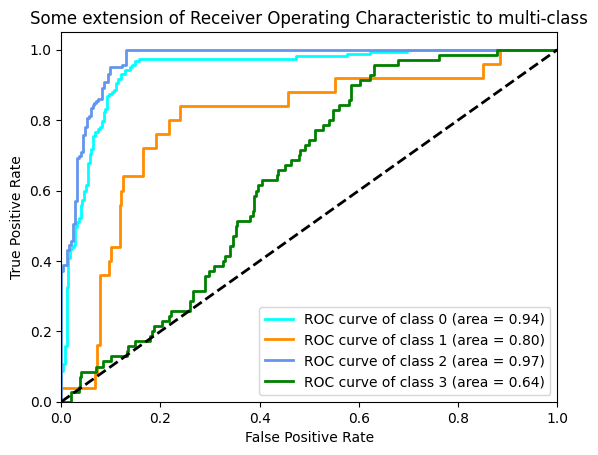

In [33]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the gnb classifier
classifier = OneVsRestClassifier(gnb)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

随机森林

In [34]:
from sklearn.model_selection import GridSearchCV

X = df_new.drop('States', axis=1)
y = df_new['States']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting the parameter grid to be searched
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Creating GridSearchCV Objects
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)

# Perform a grid search
grid_search.fit(X_train, y_train)

# Print the optimal parameters
print('Best parameters: ', grid_search.best_params_)

# Retrain the model with optimal parameters
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate and print accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy of RandomForest: ' + str(accuracy_rf))

Best parameters:  {'max_depth': 10, 'n_estimators': 100}
Accuracy of RandomForest: 0.9159090909090909


In [35]:
# Creating a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)

# Creating a Random Forest Classifier
clf.fit(X_train, y_train)

# Prediction using test sets
y_pred = clf.predict(X_test)

# Calculate and print accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(accuracy_rf))

Accuracy: 0.9181818181818182


In [36]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# Average cross-validation score
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.76031256 0.7596478  0.74677021 0.77320342 0.58851856]
Average cross-validation score:  0.7256905098400918


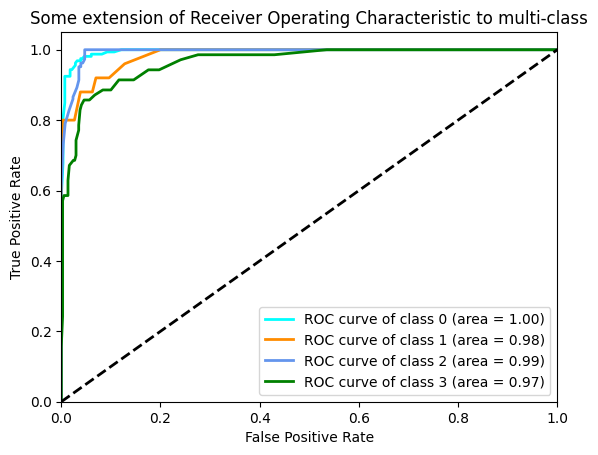

In [37]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf classifier
classifier = OneVsRestClassifier(clf)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

SVM

In [38]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X = df_new.drop('States', axis=1)
y = df_new['States']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], 'gamma':[0.1, 1, 10]}

# Creating SVM Classifiers
svc = svm.SVC()

# Creating GridSearchCV Objects
clf = GridSearchCV(svc, parameters)

# Perform a grid search
clf.fit(X_train, y_train)

# Print the optimal parameters
print("Best parameters:", clf.best_params_)

# Prediction using optimal parametric models
y_pred = clf.predict(X_test)

# Calculation accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of SVM with best parameters: ', accuracy)

Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy of SVM with best parameters:  0.975


In [39]:
# Training a model using SVM
clf_svm = OneVsRestClassifier(SVC(kernel='rbf', C=10, gamma=0.1, probability=True))
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

# Calculate and print the accuracy of SVMs
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Accuracy of SVM: ' + str(accuracy_svm))

Accuracy of SVM: 0.9704545454545455


In [40]:
scores = cross_val_score(clf_svm, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# Average cross-validation score
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.2794337  0.3202076  0.35450407 0.36977484 0.23524355]
Average cross-validation score:  0.3118327516965346


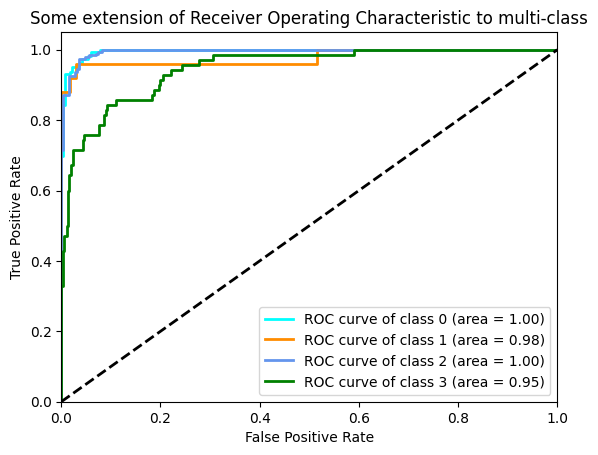

In [41]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf_svm classifier
classifier = OneVsRestClassifier(clf_svm)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

逻辑回归

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

X = df_new.drop('States', axis=1)
y = df_new['States']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {'C':[0.01, 0.1, 1, 10, 100], 'penalty':['l1', 'l2', 'elasticnet', 'none']}

# Create logistic regression models
lr = LogisticRegression()

clf = GridSearchCV(lr, parameters)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Logistic Regression with best parameters: ', accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best parameters: {'C': 0.01, 'penalty': 'none'}
Accuracy of Logistic Regression with best parameters:  0.8113636363636364


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [43]:
# Training models using logistic regression
clf_lr = LogisticRegression(C=100, penalty='l2')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# Calculate and print the accuracy of logistic regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression: ' + str(accuracy_lr))


Accuracy of Logistic Regression: 0.8113636363636364


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
scores = cross_val_score(clf_lr, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

print('Average cross-validation score: ', scores.mean())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-validation scores:  [0.5793254  0.55612676 0.54798853 0.56727561 0.54036608]
Average cross-validation score:  0.5582164763403374


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


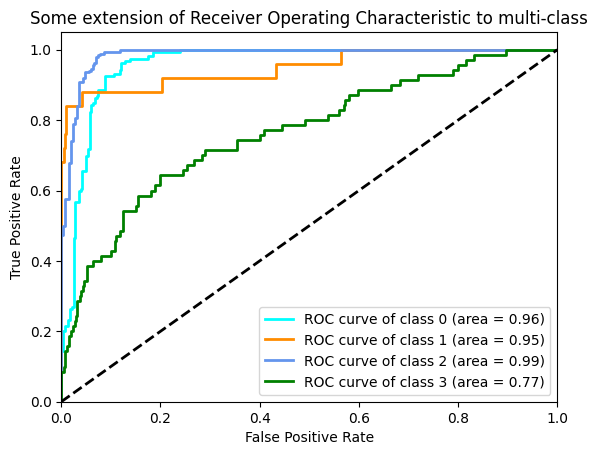

In [45]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf_lr classifier
classifier = OneVsRestClassifier(clf_lr)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

MLP

In [46]:
from sklearn.model_selection import GridSearchCV

#neural network MLP
X = df_new.drop('States', axis=1)
y = df_new['States']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=300, random_state=42), param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

print('Best parameters: ', grid_search.best_params_)

clf_mlp = grid_search.best_estimator_
clf_mlp.fit(X_train_scaled, y_train)
y_pred_mlp = clf_mlp.predict(X_test_scaled)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print('Accuracy of MLP: ' + str(accuracy_mlp))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Best parameters:  {'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}
Accuracy of MLP: 0.9068181818181819


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
# Data standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training models using neural networks (multilayer perceptrons)
clf_mlp = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=300, random_state=42)
clf_mlp.fit(X_train_scaled, y_train)
y_pred_mlp = clf_mlp.predict(X_test_scaled)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print('Accuracy of MLP: ' + str(accuracy_mlp))

Accuracy of MLP: 0.9204545454545454


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
scores = cross_val_score(clf_mlp, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.1747729  0.5064649  0.44016768 0.56344929 0.20996436]
Average cross-validation score:  0.3789638250265497


In [49]:
# Create a new DataFrame to hold the actual and predicted values in the test set
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_mlp})

# Print results
print(results_df)

      Actual  Predicted
427        3          3
1128       4          1
367        1          1
1771       1          1
350        1          1
...      ...        ...
1182       1          1
2003       3          3
479        4          4
680        3          3
1435       3          4

[440 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

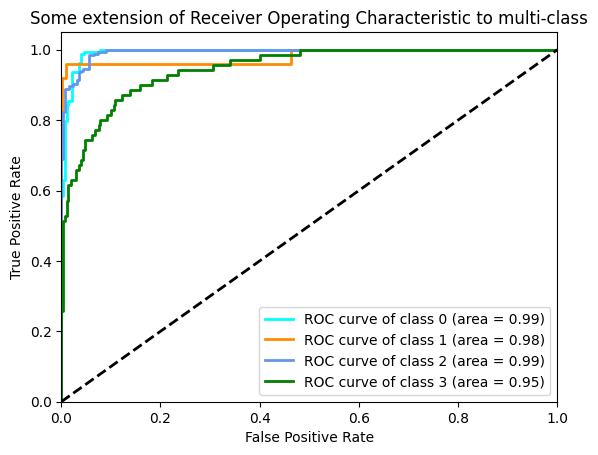

In [50]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the MLP classifier
classifier = OneVsRestClassifier(clf_mlp)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

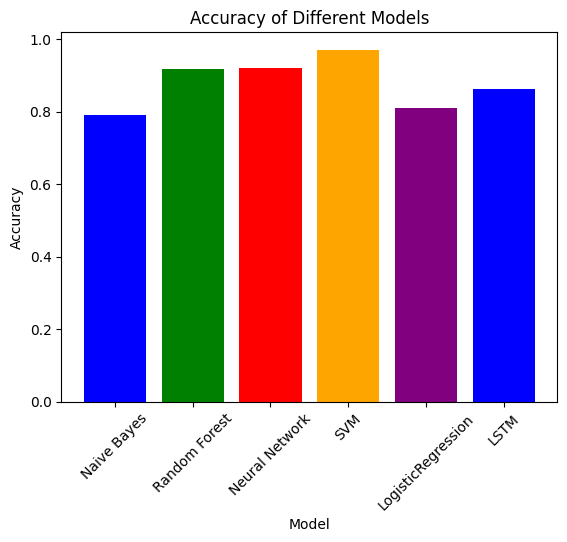

In [51]:
# Create a dictionary containing the name and corresponding accuracy of each model
accuracy_scores = {'Naive Bayes': accuracy_nb, 'Random Forest': accuracy_rf, 'Neural Network': accuracy_mlp, 'SVM': accuracy_svm, 'LogisticRegression': accuracy_lr, 'LSTM':0.863}

# Creating a Bar Chart
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xticks(rotation=45)

plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

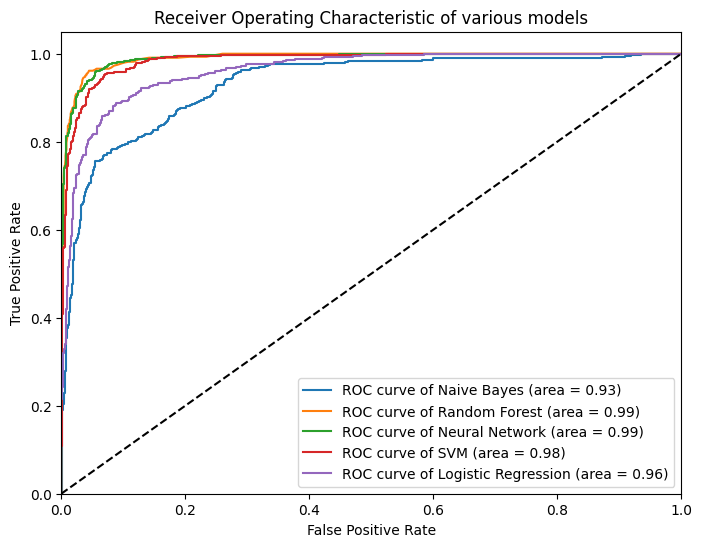

In [57]:
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lb = preprocessing.LabelBinarizer()
y_train_binarize = lb.fit_transform(y_train)
y_test_binarize = lb.transform(y_test)

classifiers = [GaussianNB(), RandomForestClassifier(n_estimators=100, random_state=42), 
               MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
               SVC(probability=True, random_state=42), LogisticRegression()]
model_names = ['Naive Bayes', 'Random Forest', 'Neural Network', 'SVM', 'Logistic Regression']
plt.figure(figsize=(8,6))
for clf, model_name in zip(classifiers, model_names):
    clf = OneVsRestClassifier(clf)
    clf.fit(X_train_scaled, y_train_binarize)  # Use y_train_binarize here
    y_score = clf.predict_proba(X_test_scaled)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_train_binarize.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])  # Use y_test_binarize here
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())  # Use y_test_binarize here
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
         label='ROC curve of %s (area = %0.2f)' % (model_name, roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of various models')
plt.legend(loc="lower right")
plt.show()